# Allstate Claims Severity

**Project Overview**

Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate's efforts to ensure a worry-free customer experience.

In this project, we will build a model to predict the cost.

**Problem Statement**

The dataset used in this project is train.csv for training and test.csv for testing the trained model which is downloaded from the link (https://www.kaggle.com/c/allstate-claims-severity/data) unzip the file to get datasets. 

This dataset has the following attributes:

Each row in this dataset represents an insurance claim. You must predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

Learning: We need to predict the 'loss' based on the other attributes. Hence, this is a regression problem.

**Data Exploration**

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


ID = 'id'
TARGET = 'loss'
SEED = 0


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_train = np.log(train[TARGET].ravel())


train.drop([ID, TARGET], axis=1, inplace=True)
test.drop([ID], axis=1, inplace=True)

print("{},{}".format(train.shape, test.shape))

ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)

features = train.columns

cats = [feat for feat in features if 'cat' in feat]
for feat in cats:
    train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]

print(train_test.describe())

(188318, 130),(125546, 130)
                cat1           cat2           cat3           cat4  \
count  313864.000000  313864.000000  313864.000000  313864.000000   
mean        0.249210       0.433118       0.054543       0.316835   
std         0.432556       0.495507       0.227086       0.465243   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       1.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                cat5           cat6           cat7           cat8  \
count  313864.000000  313864.000000  313864.000000  313864.000000   
mean        0.343604       0.299993       0.024131       0.058873   
std         0.474912       0.458255       0.153458       0.235387   
min         0.000000       0.000000       0.000000       0.000000   
25%  

(188318, 130),(125546, 130)


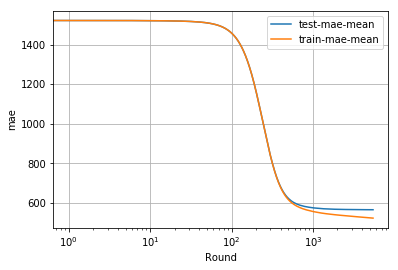

CV-Mean: 566.5095791+566.1234618460734


In [16]:
x_train = np.array(train_test.iloc[:ntrain,:])
x_test = np.array(train_test.iloc[ntrain:,:])

print("{},{}".format(train.shape, test.shape))

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
            'seed': 0,
    'colsample_bytree': 0.5,'gamma':1.7,
    'silent': 1,
    'subsample': 0.9,
    'learning_rate': 0.009,
    'objective': 'reg:linear',
    'max_depth': 23,
    'num_parallel_tree': 1,
    'min_child_weight': 8,
    'eval_metric': 'mae',
    'alpha': 5, 'lambda': 55,'random_state':1001
            
}

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

res = xgb.cv(xgb_params, dtrain, num_boost_round=15250, nfold=5, seed=SEED, stratified=False,
             early_stopping_rounds=75, verbose_eval=False, show_stdv=False, feval=xg_eval_mae, maximize=False)

res.plot(y=['test-mae-mean', 'train-mae-mean'], grid=True, logx=True)
plt.xlabel('Round')
plt.ylabel('mae')
plt.show()

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

gbdt = xgb.train(xgb_params, dtrain, best_nrounds)

submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1] = np.exp(gbdt.predict(dtest))

submission.to_csv('xgb_starter_v2.sub.csv', index=None)

**Conclusion**

The xgboost regression model is used for predicting the cost with learning rate 0.009 and evaluated using Mean Absolute Error metrics. Trained model was tested and saved as xgb_starter_v2.csv for evaluation in kaggle leaderboard. The score achieved by my model is 1121.74987.